# Sideways Guard Lab (Momentum TV)

Compare baseline TradingView-style momentum signals against anti-chop variants.

This lab can optionally regenerate comparison outputs, then visualize:
- Baseline
- Hold-bars only
- Sideways filter only
- Hold-bars + sideways filter

Use this to validate whether churn is reduced in range-bound periods (for example, APO recently).



Generating comparison outputs...
  [ok] Baseline
  [ok] Hold 5
  [ok] Sideways Filter
  [ok] Hold 5 + Sideways


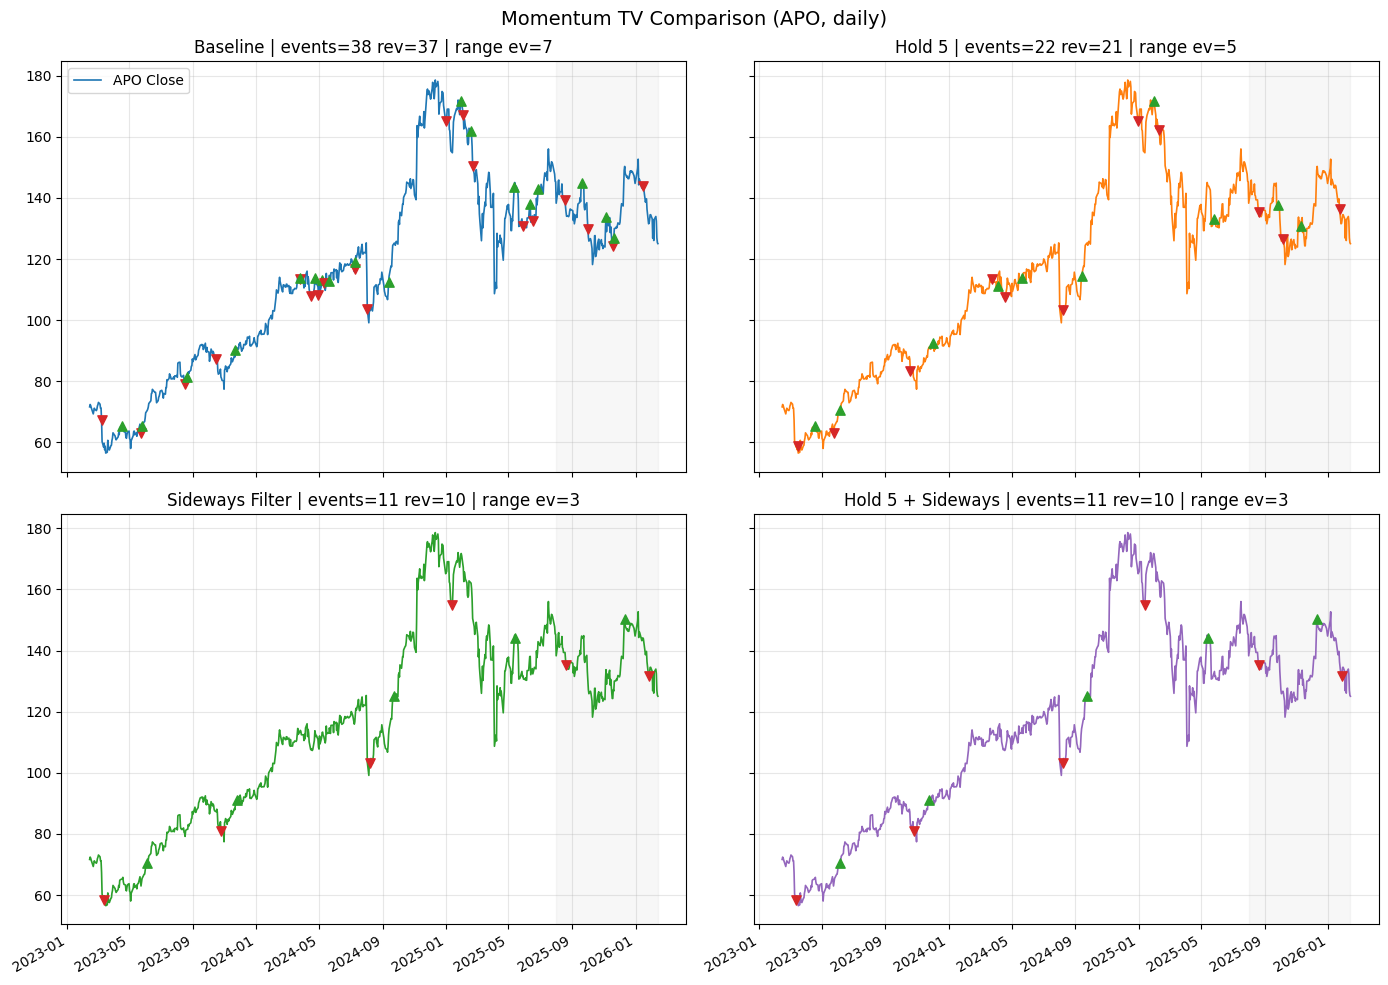

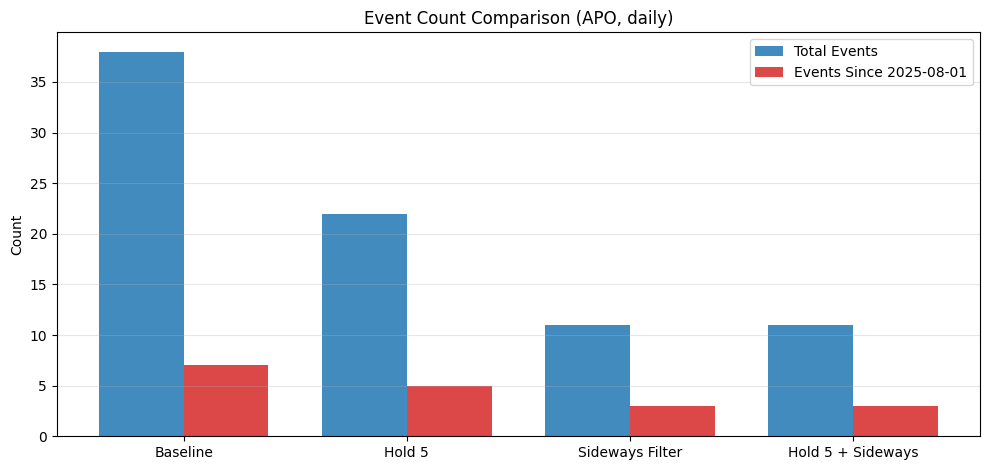


Summary Table
label | total_events | reversals | range_events | range_reversals
Baseline | 38 | 37 | 7 | 7
Hold 5 | 22 | 21 | 5 | 5
Sideways Filter | 11 | 10 | 3 | 3
Hold 5 + Sideways | 11 | 10 | 3 | 3


In [1]:
from pathlib import Path
import csv
from datetime import date, timedelta
import subprocess
import sys
import matplotlib.pyplot as plt

SYMBOL = "APO"
TIMEFRAME = "daily"  # daily | weekly | monthly
RANGE_START = date.fromisoformat("2025-08-01")
YEARS_TO_PLOT = 3  # None for full history
RUN_STRATEGY = True  # Set False to only visualize existing outputs

CONFIGS = [
    {
        "name": "baseline",
        "label": "Baseline",
        "args": [],
        "line_color": "#1f77b4",
    },
    {
        "name": "hold5",
        "label": "Hold 5",
        "args": ["--min-hold-bars", "5"],
        "line_color": "#ff7f0e",
    },
    {
        "name": "sideways",
        "label": "Sideways Filter",
        "args": [
            "--sideways-filter",
            "--er-lookback",
            "20",
            "--min-er",
            "0.25",
            "--ema-fast",
            "10",
            "--ema-slow",
            "30",
            "--min-ema-spread-pct",
            "1.0",
        ],
        "line_color": "#2ca02c",
    },
    {
        "name": "combo",
        "label": "Hold 5 + Sideways",
        "args": [
            "--min-hold-bars",
            "5",
            "--sideways-filter",
            "--er-lookback",
            "20",
            "--min-er",
            "0.25",
            "--ema-fast",
            "10",
            "--ema-slow",
            "30",
            "--min-ema-spread-pct",
            "1.0",
        ],
        "line_color": "#9467bd",
    },
]


def resolve_repo_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        if (candidate / "momentum_strategy_tv.py").exists() and (candidate / "out").exists():
            return candidate
    raise FileNotFoundError("Could not locate repo root with momentum_strategy_tv.py and out/")


repo_root = resolve_repo_root()
script_path = repo_root / "momentum_strategy_tv.py"
out_root = repo_root / "out"

if RUN_STRATEGY:
    print("Generating comparison outputs...")
    for cfg in CONFIGS:
        out_dir = out_root / f"momentum_tv_cmp_{cfg['name']}"
        latest_file = out_root / f"momentum_tv_cmp_{cfg['name']}_latest.csv"
        errors_file = out_root / f"momentum_tv_cmp_{cfg['name']}_errors.csv"

        cmd = [
            sys.executable,
            str(script_path),
            "--timeframe",
            TIMEFRAME,
            "--out-dir",
            str(out_dir),
            "--latest-file",
            str(latest_file),
            "--errors-file",
            str(errors_file),
        ] + cfg["args"]

        proc = subprocess.run(cmd, cwd=repo_root, capture_output=True, text=True)
        if proc.returncode != 0:
            print(proc.stdout)
            print(proc.stderr)
            raise RuntimeError(f"Run failed for {cfg['label']}")
        print(f"  [ok] {cfg['label']}")


def load_rows(csv_path: Path) -> list[dict[str, str]]:
    with csv_path.open("r", encoding="utf-8", newline="") as handle:
        rows = list(csv.DictReader(handle))
    if not rows:
        raise ValueError(f"No rows found in {csv_path}")
    rows.sort(key=lambda row: row["Date"])
    return rows


def summarize(rows: list[dict[str, str]]) -> dict[str, object]:
    events = [row for row in rows if (row.get("MomentumEvent") or "").strip()]
    reversals = [row for row in events if row["MomentumEvent"] in {"LONG_TO_SHORT", "SHORT_TO_LONG"}]

    range_rows = [row for row in rows if date.fromisoformat(row["Date"]) >= RANGE_START]
    range_events = [row for row in range_rows if (row.get("MomentumEvent") or "").strip()]
    range_reversals = [row for row in range_events if row["MomentumEvent"] in {"LONG_TO_SHORT", "SHORT_TO_LONG"}]

    return {
        "events": len(events),
        "reversals": len(reversals),
        "range_events": len(range_events),
        "range_reversals": len(range_reversals),
    }


loaded: dict[str, list[dict[str, str]]] = {}
for cfg in CONFIGS:
    csv_path = out_root / f"momentum_tv_cmp_{cfg['name']}" / f"{SYMBOL}.csv"
    if not csv_path.exists():
        raise FileNotFoundError(
            f"Missing {csv_path}. Set RUN_STRATEGY=True or run the script manually for this config."
        )
    loaded[cfg["name"]] = load_rows(csv_path)

# Baseline dates/prices for shared x-axis.
base_rows = loaded["baseline"]
dates = [date.fromisoformat(row["Date"]) for row in base_rows]
closes = [float(row["Close"]) for row in base_rows]

if YEARS_TO_PLOT is None:
    start_idx = 0
else:
    window_start = dates[-1] - timedelta(days=365 * YEARS_TO_PLOT)
    start_idx = next((idx for idx, row_date in enumerate(dates) if row_date >= window_start), 0)

plot_dates = dates[start_idx:]
plot_closes = closes[start_idx:]

event_style = {
    "LONG_ENTRY": {"color": "#2ca02c", "marker": "^"},
    "SHORT_TO_LONG": {"color": "#2ca02c", "marker": "^"},
    "SHORT_ENTRY": {"color": "#d62728", "marker": "v"},
    "LONG_TO_SHORT": {"color": "#d62728", "marker": "v"},
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes_flat = list(axes.flatten())

summary_rows: list[tuple[str, int, int, int, int]] = []
for axis, cfg in zip(axes_flat, CONFIGS, strict=True):
    rows = loaded[cfg["name"]]
    stats = summarize(rows)
    summary_rows.append((cfg["label"], stats["events"], stats["reversals"], stats["range_events"], stats["range_reversals"]))

    row_dates = [date.fromisoformat(row["Date"]) for row in rows]
    row_closes = [float(row["Close"]) for row in rows]

    axis.plot(plot_dates, plot_closes, color=cfg["line_color"], linewidth=1.2, label=f"{SYMBOL} Close")

    events = [
        (idx, (row.get("MomentumEvent") or "").strip())
        for idx, row in enumerate(rows)
        if (row.get("MomentumEvent") or "").strip()
    ]
    window_events = [(idx, event) for idx, event in events if idx >= start_idx]

    for idx, event in window_events:
        style = event_style.get(event)
        if style is None:
            continue
        axis.scatter(
            [row_dates[idx]],
            [row_closes[idx]],
            s=45,
            marker=style["marker"],
            color=style["color"],
            zorder=6,
        )

    axis.axvspan(RANGE_START, plot_dates[-1], color="#999999", alpha=0.08)
    axis.grid(alpha=0.3)
    axis.set_title(
        f"{cfg['label']} | events={stats['events']} rev={stats['reversals']} "
        f"| range ev={stats['range_events']}"
    )

axes_flat[0].legend(loc="upper left")
fig.suptitle(f"Momentum TV Comparison ({SYMBOL}, {TIMEFRAME})", fontsize=14)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

labels = [row[0] for row in summary_rows]
total_events = [row[1] for row in summary_rows]
range_events = [row[3] for row in summary_rows]

fig2, ax2 = plt.subplots(figsize=(10, 4.8))
x = list(range(len(labels)))
bar_w = 0.38
ax2.bar([p - bar_w / 2 for p in x], total_events, width=bar_w, color="#1f77b4", alpha=0.85, label="Total Events")
ax2.bar([p + bar_w / 2 for p in x], range_events, width=bar_w, color="#d62728", alpha=0.85, label=f"Events Since {RANGE_START}")
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_ylabel("Count")
ax2.set_title(f"Event Count Comparison ({SYMBOL}, {TIMEFRAME})")
ax2.grid(axis="y", alpha=0.3)
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

print("\nSummary Table")
print("label | total_events | reversals | range_events | range_reversals")
for row in summary_rows:
    print(f"{row[0]} | {row[1]} | {row[2]} | {row[3]} | {row[4]}")

